In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
pwd

'c:\\workspace\\deepnoid\\deepnoid\\PBL2'

In [30]:
# %cd '/content/drive/MyDrive/Colab Notebooks'

In [31]:
# # zip 파일 압축 해제
# import zipfile
# import os

# # 파일 경로
# zip_path = '/content/drive/MyDrive/Colab Notebooks/knife2.v1i.voc.zip'
# extract_path = '/content/drive/MyDrive/Colab Notebooks/knife2.v1i.voc'

# # 디렉토리가 존재하지 않으면 생성
# os.makedirs(extract_path, exist_ok=True)

# # zip 파일 열기 및 압축 해제
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print('압축 해제 완료')


In [32]:
# !pip install roboflow

In [33]:
from roboflow import Roboflow

In [34]:
# # roboflow에서 다운 받을 데이터셋 명세
# USER_NAME = 'lee-inji'
# PROJECT_NAME = 'knife2-smv1v'
# VERSION = 1

# rf = Roboflow(api_key='mGlKFXmpv99n8uG57pep')
# project = rf.workspace(USER_NAME).project(PROJECT_NAME)
# dataset = project.version(VERSION).download('voc')

In [35]:
# !pip install xmltodict

In [36]:
import os
from glob import glob
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import seaborn as sns
import xmltodict as xmd

In [37]:
class_name = {
    1: 'Knife'
}

NUM_CLASSES = len(class_name) + 1

In [38]:
def load_from_directory(path):
    if os.path.isfile(path+'/annot.csv'):
        df = pd.read_csv(path+'/annot.csv')
        print(f"Loaded {path+'/annot.csv'}")
    else:
        df = pd.DataFrame(columns=['img', 'xml'])
        flist = glob(path+'/*.jpg')

        for i, img in tqdm(enumerate( flist), total=len(flist), desc=f'Loading data from {path}...' ):
            xml = img[:-3] + 'xml'
            df.loc[i] = [img, xml]

        df.to_csv(path+'/annot.csv', index=False)

    return df

train_df = load_from_directory('./knife/train')
valid_df = load_from_directory('./knife/valid')
test_df  = load_from_directory('./knife/test')

Loaded ./knife/train/annot.csv


Loading data from ./knife/valid...:   0%|          | 0/100 [00:00<?, ?it/s]

Loading data from ./knife/test...:   0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
train_df.head(3)

,img,xml
0,./knife/train\H_8211-91-0000_01_543_png.rf.2df...,./knife/train\H_8211-91-0000_01_543_png.rf.2df...
1,./knife/train\H_8211-91-0000_01_544_png.rf.f54...,./knife/train\H_8211-91-0000_01_544_png.rf.f54...
2,./knife/train\H_8211-91-0000_01_545_png.rf.383...,./knife/train\H_8211-91-0000_01_545_png.rf.383...


In [40]:
import cv2
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [42]:
class Data_Structure(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.image_ids = self.dataframe.index

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.dataframe.index[idx]
        fname, xml = self.dataframe.loc[idx]

        image = cv2.imread(fname, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image file {fname} not found")

        image = image[:, :, ::-1].copy()  # Convert BGR to RGB
        image = cv2.resize(image, (512, 512), cv2.INTER_LINEAR) / 255.

        # XML annotation 불러오기 및 dict타입 구성
        with open(xml, 'r') as f:
            annot = xmd.parse(f.read())['annotation']

        width, height = int(annot['size']['width']), int(annot['size']['height'])
        boxes = []
        labels = []
        areas = []

        # 여러 개의 object를 처리
        objects = annot.get('object', [])
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            object_class_name = obj['name']
            object_class = [k for k, v in class_name.items() if v == object_class_name][0]  # 클래스 이름에서 번호로 매핑

            xmin, xmax, ymin, ymax = [int(obj['bndbox'][value]) for value in obj['bndbox']]

            # Bounding box normalization => 0~1
            box = np.array([[xmin, ymin, xmax, ymax]], dtype=np.float32)
            bbox_w, bbox_h = box[0, 2] - box[0, 0], box[0, 3] - box[0, 1]

            # 바운딩 박스의 너비와 높이가 유효한지 확인
            if bbox_w > 0 and bbox_h > 0:
                box[0, ::2] = box[0, ::2] / width * 512
                box[0, 1::2] = box[0, 1::2] / height * 512

                boxes.append(box[0])
                labels.append(object_class)
                areas.append(bbox_w * bbox_h)

        if not boxes:  # If no valid boxes found
            boxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
            areas = np.zeros((0,), dtype=np.float32)

        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)
        areas = np.array(areas, dtype=np.float32)

        # 학습용 레이블 데이터 생성
        target = {
            'image_id': torch.as_tensor(image_id),
            'boxes': torch.from_numpy(boxes),
            'labels': torch.as_tensor(labels),
            'area': torch.as_tensor(areas),
            'iscrowd': torch.from_numpy(np.zeros(len(boxes)))
        }

        return (
            torch.from_numpy(image).float().permute(2, 0, 1),  # 순서 변경 -> (channel, horizontal, vertical)
            target
        )

In [43]:
TRAIN_DATA = Data_Structure(train_df)
VAL_DATA = Data_Structure(valid_df)

In [44]:
TRAIN_DATA[0]

(tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
          [0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
          [0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353]],
 
         [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
          [0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
          [0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353]],
 
         [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ...,

In [45]:
def Preview(data, model=None, device='cuda', iou_threshold=0.5, score_threshold=0):
    plt.figure(figsize=(12,12))
    plt.imshow(data[0].permute(1,2,0).numpy())
    ax = plt.gca()
    for i,box in enumerate(data[1]['boxes']):
        x1,y1, x2, y2 = box
        ground_truth = Rectangle(
                            (x1,y1),
                            x2-x1, y2-y1,
                            edgecolor='blue',
                            linewidth=3,
                            fill=False )
        ax.add_patch(ground_truth)
        plt.text(10, 10, f'[Ground Truth]:' + f"{class_name[data[1]['labels'][i].item()]}", color='blue', fontsize=12)

    if model is not None:
        model.eval()
        rtn = model( torch.unsqueeze( data[0], 0 ).to(device) ) # 차원 확장
        class_pred = rtn[0]['labels'].detach().cpu()
        bbox = rtn[0]['boxes'].detach().cpu()
        scores = rtn[0]['scores'].detach().cpu()
        get = torchvision.ops.nms(boxes=bbox, scores=scores, iou_threshold=iou_threshold)

        for i, pred in enumerate(class_pred):
            if i not in get: continue
            if scores[i]<score_threshold: continue

            x1,y1, x2, y2 = bbox[i]
            prediction =  Rectangle(
                                (x1,y1), x2-x1,  y2-y1,
                                edgecolor='red', linewidth=3, fill=False )
            ax.add_patch( prediction )
            plt.text(10, 20+10*i, f'[Prediction]  : {class_name[pred.item()]} - {scores[i]:.4f}', color='red', fontsize=12)
    plt.show()

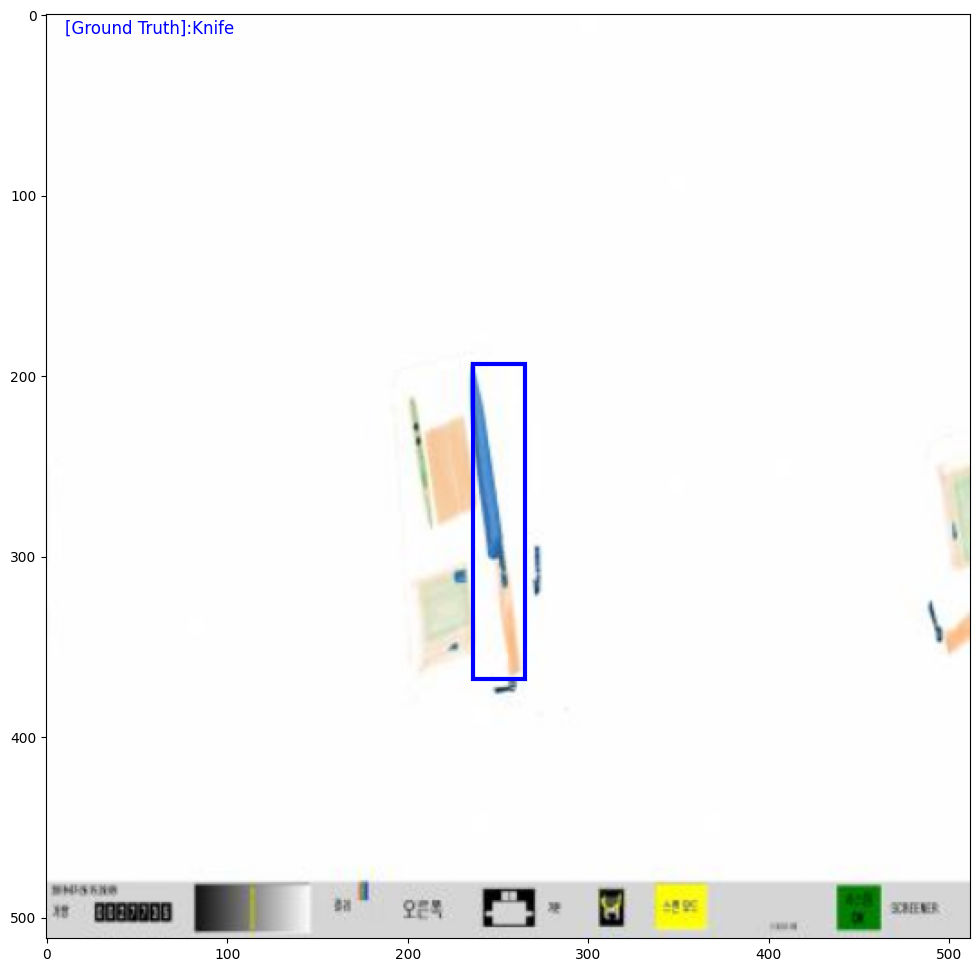

In [46]:
Preview(TRAIN_DATA[99])

In [47]:
from torch.utils.data import DataLoader

In [48]:
BATCH_SIZE = 8
NUM_WORKERS = 8

In [49]:
def collate_fn(batch):
    return tuple(zip(*batch)) # 다양한 크기의 shape를 다루기 위해 조정

In [50]:
train_loader = DataLoader(TRAIN_DATA,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          collate_fn=collate_fn)

val_loader = DataLoader(VAL_DATA,
                        batch_size=4,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        collate_fn=collate_fn)

In [51]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [52]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None, min_size=512, max_size=512)

In [53]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

1024


In [54]:
model = model.to('cuda')

In [55]:
# torchvision 코드를 받아 사용 - 일부 수정된 코드를 받아서 사용합니다.
!git clone https://github.com/Adrian123K/torch_ref

fatal: destination path 'torch_ref' already exists and is not an empty directory.


In [56]:
import sys
sys.path.append('./torch_ref/torchvision_ref') # 경로 추가

In [57]:
import torch_ref.torchvision_ref.engine as engine

In [58]:
# Params: 가중치 업데이트
params = [p for p in model.parameters() if p.requires_grad]

# SGD Optimizer
optimizer = torch.optim.SGD(params, lr=0.01, weight_decay=0.0005)

# lr_scheduler로 현재 learning rate를 3에폭 마다 95%로 감소
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

In [59]:
num_epochs = 20

for epoch in range(num_epochs):
    engine.train_one_epoch(model, optimizer, train_loader, 'cuda', epoch, print_freq=50)

    # lr_scheduler 실행
    lr_scheduler.step()

    engine.evaluate(model, val_loader, device='cuda')
    torch.save(model.state_dict(), f"./last_epoch_model.pth")

In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'